In [1]:
import random 
import warnings
warnings.filterwarnings("ignore", message=".*Signature.*numpy.longdouble.*")

In [2]:
# graphs.RandomTree(7).show()

In [3]:
# definiramo funkcijo za Somborjev indeks

def general_sombor_index(G, alpha):
    alpha = RR(alpha)
    deg = G.degree()  
    val = 0
    for u, v in G.edges(labels=False):
        du = deg[u]
        dv = deg[v]
        val += (du**2 + dv**2)**alpha
    return RR(val)

# definirajmo funkcijo za največjo stopnjo - delto

def max_degree(G):
    return max(G.degree(v) for v in G.vertices()) if G.num_verts() > 0 else 0

# MAJHNI GRAFI (n≤10)

In [4]:
# funkcija, ki vrne vse variacije drevesa z n vozlišči in vsemi možnimi deltami

def classify_trees_by_max_degree_sage(n):
    """
    Vrne slovar:
        Δ -> [seznam neizomorfnih dreves kot Sage Graph objekti]
    """
    result = {}

    for T in graphs.trees(n):
        # izračun maximalne stopnje – kompatibilno z vsemi verzijami Sage
        delta = max(T.degree(v) for v in T.vertices()) if T.num_verts() > 0 else 0

        if delta not in result:
            result[delta] = []

        result[delta].append(T)

    return result

In [ ]:
# funkcija, ki vrne drevo z največjim indeksom iz seznama vseh variacij

def systematic_best_trees_all(n, alpha, return_all_best=True):
    best_val = -infinity
    best_list = []   # tukaj bomo shranili: (edges, delta)

    trees_by_delta = classify_trees_by_max_degree_sage(n)

    for delta in trees_by_delta:
        for T in trees_by_delta[delta]:

            val = general_sombor_index(T, alpha)
            edges = T.edges(labels=False)
            maxdeg = max(T.degree(v) for v in T.vertices())

            # Nova najboljša vrednost
            if val > best_val + 1e-12:
                best_val = val
                best_list = [(edges, maxdeg)]

            # Če je enako najboljši in želimo vse najboljše
            elif abs(val - best_val) <= 1e-12 and return_all_best:
                best_list.append((edges, maxdeg))

    return best_val, best_list

In [6]:
# funkcija, ki za vsak delta zračuna pri katerem drevesu je najboljši somborjev indeks

def best_sombor_by_delta(n, alpha):
    """
    Za vsak Δ izračuna največji Somborjev indeks in vrne
    najboljša drevesa ter njihove Δ in robove.

    Vrne slovar:
    {
        Δ : {
                "best_val": vrednost Sombor indeksa,
                "best_trees": [ (edges, delta), ... ]
            }
    }
    """
    result = {}
    trees_by_delta = classify_trees_by_max_degree_sage(n)

    for delta, tree_list in trees_by_delta.items():

        best_val = -infinity
        best_trees = []

        for T in tree_list:

            val = general_sombor_index(T, alpha)
            edges = T.edges(labels=False)
            maxdeg = max(T.degree(v) for v in T.vertices())

            # ali je to novo najboljše drevo pri tem Δ?
            if val > best_val + 1e-12:
                best_val = val
                best_trees = [(edges, maxdeg)]

            elif abs(val - best_val) <= 1e-12:
                best_trees.append((edges, maxdeg))

        result[delta] = {
            "best_val": best_val,
            "best_trees": best_trees
        }

    return result

## Uporabljene alfe

In [7]:
alpha_values = [0.05, 0.45, 0.5, 0.55, 0.95]

# n=2

In [8]:
n = 2

for alpha in alpha_values:
    alpha_R = RR(alpha)

    print("="*60)
    print(f"α = {alpha_R.n(digits=3)}")
    print("="*60)

    # 1. izračun za vsak Δ
    res = best_sombor_by_delta(n, alpha_R)

    # izpis rezultatov po Δ
    for delta in sorted(res.keys()):
        print(f"Δ = {delta}")
        print("  največji Sombor indeks =", res[delta]["best_val"])
        for edges, d in res[delta]["best_trees"]:
            print("  edges:", edges)
        print()

    # 2. poišči globalni maksimum med vsemi drevesi pri tem α
    best_global_val, best_global_list = systematic_best_trees_all(n, alpha_R)

    # 3. določimo pri katerem Δ ta maksimum nastopi
    max_delta = best_global_list[0][1]   # drugi element v (edges, delta)

    print(f"→ GLOBALNI MAKSIMUM pri α = {alpha_R.n(digits=3)}")
    print(f"   Δ = {max_delta},  Sombor indeks = {best_global_val}")

    # izpišemo najboljše drevo/drevesa
    for edges, d in best_global_list:
        print("   najboljše drevo, edges:", edges)

    print("\n")

α = 0.0500
Δ = 1
  največji Sombor indeks = 1.03526492384138
  edges: [(0, 1)]

→ GLOBALNI MAKSIMUM pri α = 0.0500
   Δ = 1,  Sombor indeks = 1.03526492384138
   najboljše drevo, edges: [(0, 1)]


α = 0.450
Δ = 1
  največji Sombor indeks = 1.36604025675440
  edges: [(0, 1)]

→ GLOBALNI MAKSIMUM pri α = 0.450
   Δ = 1,  Sombor indeks = 1.36604025675440
   najboljše drevo, edges: [(0, 1)]


α = 0.500
Δ = 1
  največji Sombor indeks = 1.41421356237310
  edges: [(0, 1)]

→ GLOBALNI MAKSIMUM pri α = 0.500
   Δ = 1,  Sombor indeks = 1.41421356237310
   najboljše drevo, edges: [(0, 1)]


α = 0.550
Δ = 1
  največji Sombor indeks = 1.46408569594563
  edges: [(0, 1)]

→ GLOBALNI MAKSIMUM pri α = 0.550
   Δ = 1,  Sombor indeks = 1.46408569594563
   najboljše drevo, edges: [(0, 1)]


α = 0.950
Δ = 1
  največji Sombor indeks = 1.93187265784969
  edges: [(0, 1)]

→ GLOBALNI MAKSIMUM pri α = 0.950
   Δ = 1,  Sombor indeks = 1.93187265784969
   najboljše drevo, edges: [(0, 1)]




# n=3

In [9]:
n = 3

for alpha in alpha_values:
    alpha_R = RR(alpha)

    print("="*60)
    print(f"α = {alpha_R.n(digits=3)}")
    print("="*60)

    # 1. izračun za vsak Δ
    res = best_sombor_by_delta(n, alpha_R)

    # izpis rezultatov po Δ
    for delta in sorted(res.keys()):
        print(f"Δ = {delta}")
        print("  največji Sombor indeks =", res[delta]["best_val"])
        for edges, d in res[delta]["best_trees"]:
            print("  edges:", edges)
        print()

    # 2. poišči globalni maksimum med vsemi drevesi pri tem α
    best_global_val, best_global_list = systematic_best_trees_all(n, alpha_R)

    # 3. določimo pri katerem Δ ta maksimum nastopi
    max_delta = best_global_list[0][1]   # drugi element v (edges, delta)

    print(f"→ GLOBALNI MAKSIMUM pri α = {alpha_R.n(digits=3)}")
    print(f"   Δ = {max_delta},  Sombor indeks = {best_global_val}")

    # izpišemo najboljše drevo/drevesa
    for edges, d in best_global_list:
        print("   najboljše drevo, edges:", edges)

    print("\n")

α = 0.0500
Δ = 2
  največji Sombor indeks = 2.16759677346874
  edges: [(0, 1), (0, 2)]

→ GLOBALNI MAKSIMUM pri α = 0.0500
   Δ = 2,  Sombor indeks = 2.16759677346874
   najboljše drevo, edges: [(0, 1), (0, 2)]


α = 0.450
Δ = 2
  največji Sombor indeks = 4.12635413536159
  edges: [(0, 1), (0, 2)]

→ GLOBALNI MAKSIMUM pri α = 0.450
   Δ = 2,  Sombor indeks = 4.12635413536159
   najboljše drevo, edges: [(0, 1), (0, 2)]


α = 0.500
Δ = 2
  največji Sombor indeks = 4.47213595499958
  edges: [(0, 1), (0, 2)]

→ GLOBALNI MAKSIMUM pri α = 0.500
   Δ = 2,  Sombor indeks = 4.47213595499958
   najboljše drevo, edges: [(0, 1), (0, 2)]


α = 0.550
Δ = 2
  največji Sombor indeks = 4.84689373328531
  edges: [(0, 1), (0, 2)]

→ GLOBALNI MAKSIMUM pri α = 0.550
   Δ = 2,  Sombor indeks = 4.84689373328531
   najboljše drevo, edges: [(0, 1), (0, 2)]


α = 0.950
Δ = 2
  največji Sombor indeks = 9.22680834590588
  edges: [(0, 1), (0, 2)]

→ GLOBALNI MAKSIMUM pri α = 0.950
   Δ = 2,  Sombor indeks = 9.2268

# n=4

In [10]:
n = 4

for alpha in alpha_values:
    alpha_R = RR(alpha)

    print("="*60)
    print(f"α = {alpha_R.n(digits=3)}")
    print("="*60)

    # 1. izračun za vsak Δ
    res = best_sombor_by_delta(n, alpha_R)

    # izpis rezultatov po Δ
    for delta in sorted(res.keys()):
        print(f"Δ = {delta}")
        print("  največji Sombor indeks =", res[delta]["best_val"])
        for edges, d in res[delta]["best_trees"]:
            print("  edges:", edges)
        print()

    # 2. poišči globalni maksimum med vsemi drevesi pri tem α
    best_global_val, best_global_list = systematic_best_trees_all(n, alpha_R)

    # 3. določimo pri katerem Δ ta maksimum nastopi
    max_delta = best_global_list[0][1]   # drugi element v (edges, delta)

    print(f"→ GLOBALNI MAKSIMUM pri α = {alpha_R.n(digits=3)}")
    print(f"   Δ = {max_delta},  Sombor indeks = {best_global_val}")

    # izpišemo najboljše drevo/drevesa
    for edges, d in best_global_list:
        print("   najboljše drevo, edges:", edges)

    print("\n")

α = 0.0500
Δ = 2
  največji Sombor indeks = 3.27716624553658
  edges: [(0, 1), (0, 3), (1, 2)]

Δ = 3
  največji Sombor indeks = 3.36605536290589
  edges: [(0, 1), (0, 2), (0, 3)]

→ GLOBALNI MAKSIMUM pri α = 0.0500
   Δ = 3,  Sombor indeks = 3.36605536290589
   najboljše drevo, edges: [(0, 1), (0, 2), (0, 3)]


α = 0.450
Δ = 2
  največji Sombor indeks = 6.67547539000011
  edges: [(0, 1), (0, 3), (1, 2)]

Δ = 3
  največji Sombor indeks = 8.45514879379336
  edges: [(0, 1), (0, 2), (0, 3)]

→ GLOBALNI MAKSIMUM pri α = 0.450
   Δ = 3,  Sombor indeks = 8.45514879379336
   najboljše drevo, edges: [(0, 1), (0, 2), (0, 3)]


α = 0.500
Δ = 2
  največji Sombor indeks = 7.30056307974577
  edges: [(0, 1), (0, 3), (1, 2)]

Δ = 3
  največji Sombor indeks = 9.48683298050514
  edges: [(0, 1), (0, 2), (0, 3)]

→ GLOBALNI MAKSIMUM pri α = 0.500
   Δ = 3,  Sombor indeks = 9.48683298050514
   najboljše drevo, edges: [(0, 1), (0, 2), (0, 3)]


α = 0.550
Δ = 2
  največji Sombor indeks = 7.98523012487231
  

# n=5

In [11]:
n = 5

for alpha in alpha_values:
    alpha_R = RR(alpha)

    print("="*60)
    print(f"α = {alpha_R.n(digits=3)}")
    print("="*60)

    # 1. izračun za vsak Δ
    res = best_sombor_by_delta(n, alpha_R)

    # izpis rezultatov po Δ
    for delta in sorted(res.keys()):
        print(f"Δ = {delta}")
        print("  največji Sombor indeks =", res[delta]["best_val"])
        for edges, d in res[delta]["best_trees"]:
            print("  edges:", edges)
        print()

    # 2. poišči globalni maksimum med vsemi drevesi pri tem α
    best_global_val, best_global_list = systematic_best_trees_all(n, alpha_R)

    # 3. določimo pri katerem Δ ta maksimum nastopi
    max_delta = best_global_list[0][1]   # drugi element v (edges, delta)

    print(f"→ GLOBALNI MAKSIMUM pri α = {alpha_R.n(digits=3)}")
    print(f"   Δ = {max_delta},  Sombor indeks = {best_global_val}")

    # izpišemo najboljše drevo/drevesa
    for edges, d in best_global_list:
        print("   najboljše drevo, edges:", edges)

    print("\n")

α = 0.0500
Δ = 2
  največji Sombor indeks = 4.38673571760443
  edges: [(0, 1), (0, 3), (1, 2), (3, 4)]

Δ = 3
  največji Sombor indeks = 4.46466959319389
  edges: [(0, 1), (0, 3), (0, 4), (1, 2)]

Δ = 4
  največji Sombor indeks = 4.60874243131641
  edges: [(0, 1), (0, 2), (0, 3), (0, 4)]

→ GLOBALNI MAKSIMUM pri α = 0.0500
   Δ = 4,  Sombor indeks = 4.60874243131641
   najboljše drevo, edges: [(0, 1), (0, 2), (0, 3), (0, 4)]


α = 0.450
Δ = 2
  največji Sombor indeks = 9.22459664463864
  edges: [(0, 1), (0, 3), (1, 2), (3, 4)]

Δ = 3
  največji Sombor indeks = 10.8715144444270
  edges: [(0, 1), (0, 3), (0, 4), (1, 2)]

Δ = 4
  največji Sombor indeks = 14.3140327308418
  edges: [(0, 1), (0, 2), (0, 3), (0, 4)]

→ GLOBALNI MAKSIMUM pri α = 0.450
   Δ = 4,  Sombor indeks = 14.3140327308418
   najboljše drevo, edges: [(0, 1), (0, 2), (0, 3), (0, 4)]


α = 0.500
Δ = 2
  največji Sombor indeks = 10.1289902044920
  edges: [(0, 1), (0, 3), (1, 2), (3, 4)]

Δ = 3
  največji Sombor indeks = 12.1

# n=6

In [12]:
n = 6

for alpha in alpha_values:
    alpha_R = RR(alpha)

    print("="*60)
    print(f"α = {alpha_R.n(digits=3)}")
    print("="*60)

    # 1. izračun za vsak Δ
    res = best_sombor_by_delta(n, alpha_R)

    # izpis rezultatov po Δ
    for delta in sorted(res.keys()):
        print(f"Δ = {delta}")
        print("  največji Sombor indeks =", res[delta]["best_val"])
        for edges, d in res[delta]["best_trees"]:
            print("  edges:", edges)
        print()

    # 2. poišči globalni maksimum med vsemi drevesi pri tem α
    best_global_val, best_global_list = systematic_best_trees_all(n, alpha_R)

    # 3. določimo pri katerem Δ ta maksimum nastopi
    max_delta = best_global_list[0][1]   # drugi element v (edges, delta)

    print(f"→ GLOBALNI MAKSIMUM pri α = {alpha_R.n(digits=3)}")
    print(f"   Δ = {max_delta},  Sombor indeks = {best_global_val}")

    # izpišemo najboljše drevo/drevesa
    for edges, d in best_global_list:
        print("   najboljše drevo, edges:", edges)

    print("\n")

α = 0.0500
Δ = 2
  največji Sombor indeks = 5.49630518967227
  edges: [(0, 1), (0, 4), (1, 2), (2, 3), (4, 5)]

Δ = 3
  največji Sombor indeks = 5.64355698997166
  edges: [(0, 1), (0, 4), (0, 5), (1, 2), (1, 3)]

Δ = 4
  največji Sombor indeks = 5.70194155986322
  edges: [(0, 1), (0, 3), (0, 4), (0, 5), (1, 2)]

Δ = 5
  največji Sombor indeks = 5.88462336394871
  edges: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5)]

→ GLOBALNI MAKSIMUM pri α = 0.0500
   Δ = 5,  Sombor indeks = 5.88462336394871
   najboljše drevo, edges: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5)]


α = 0.450
Δ = 2
  največji Sombor indeks = 11.7737178992772
  edges: [(0, 1), (0, 4), (1, 2), (2, 3), (4, 5)]

Δ = 3
  največji Sombor indeks = 14.9452776986243
  edges: [(0, 1), (0, 4), (0, 5), (1, 2), (1, 3)]

Δ = 4
  največji Sombor indeks = 16.6487261588689
  edges: [(0, 1), (0, 3), (0, 4), (0, 5), (1, 2)]

Δ = 5
  največji Sombor indeks = 21.6624718279813
  edges: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5)]

→ GLOBALNI MAKSIMUM pr

# n=7

In [13]:
n = 7

for alpha in alpha_values:
    alpha_R = RR(alpha)

    print("="*60)
    print(f"α = {alpha_R.n(digits=3)}")
    print("="*60)

    # 1. izračun za vsak Δ
    res = best_sombor_by_delta(n, alpha_R)

    # izpis rezultatov po Δ
    for delta in sorted(res.keys()):
        print(f"Δ = {delta}")
        print("  največji Sombor indeks =", res[delta]["best_val"])
        for edges, d in res[delta]["best_trees"]:
            print("  edges:", edges)
        print()

    # 2. poišči globalni maksimum med vsemi drevesi pri tem α
    best_global_val, best_global_list = systematic_best_trees_all(n, alpha_R)

    # 3. določimo pri katerem Δ ta maksimum nastopi
    max_delta = best_global_list[0][1]   # drugi element v (edges, delta)

    print(f"→ GLOBALNI MAKSIMUM pri α = {alpha_R.n(digits=3)}")
    print(f"   Δ = {max_delta},  Sombor indeks = {best_global_val}")

    # izpišemo najboljše drevo/drevesa
    for edges, d in best_global_list:
        print("   najboljše drevo, edges:", edges)

    print("\n")

α = 0.0500
Δ = 2
  največji Sombor indeks = 6.60587466174012
  edges: [(0, 1), (0, 4), (1, 2), (2, 3), (4, 5), (5, 6)]

Δ = 3
  največji Sombor indeks = 6.76174241291905
  edges: [(0, 1), (0, 4), (1, 2), (1, 3), (4, 5), (4, 6)]

Δ = 4
  največji Sombor indeks = 6.87521267517925
  edges: [(0, 1), (0, 4), (0, 5), (0, 6), (1, 2), (1, 3)]

Δ = 5
  največji Sombor indeks = 6.97486529247889
  edges: [(0, 1), (0, 3), (0, 4), (0, 5), (0, 6), (1, 2)]

Δ = 6
  največji Sombor indeks = 7.18722658362132
  edges: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6)]

→ GLOBALNI MAKSIMUM pri α = 0.0500
   Δ = 6,  Sombor indeks = 7.18722658362132
   najboljše drevo, edges: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6)]


α = 0.450
Δ = 2
  največji Sombor indeks = 14.3228391539157
  edges: [(0, 1), (0, 4), (1, 2), (2, 3), (4, 5), (5, 6)]

Δ = 3
  največji Sombor indeks = 17.6166747534923
  edges: [(0, 1), (0, 4), (1, 2), (1, 3), (4, 5), (4, 6)]

Δ = 4
  največji Sombor indeks = 20.6289900232642
  edges: 

# n=8

In [14]:
n = 8

for alpha in alpha_values:
    alpha_R = RR(alpha)

    print("="*60)
    print(f"α = {alpha_R.n(digits=3)}")
    print("="*60)

    # 1. izračun za vsak Δ
    res = best_sombor_by_delta(n, alpha_R)

    # izpis rezultatov po Δ
    for delta in sorted(res.keys()):
        print(f"Δ = {delta}")
        print("  največji Sombor indeks =", res[delta]["best_val"])
        for edges, d in res[delta]["best_trees"]:
            print("  edges:", edges)
        print()

    # 2. poišči globalni maksimum med vsemi drevesi pri tem α
    best_global_val, best_global_list = systematic_best_trees_all(n, alpha_R)

    # 3. določimo pri katerem Δ ta maksimum nastopi
    max_delta = best_global_list[0][1]   # drugi element v (edges, delta)

    print(f"→ GLOBALNI MAKSIMUM pri α = {alpha_R.n(digits=3)}")
    print(f"   Δ = {max_delta},  Sombor indeks = {best_global_val}")

    # izpišemo najboljše drevo/drevesa
    for edges, d in best_global_list:
        print("   najboljše drevo, edges:", edges)

    print("\n")

α = 0.0500
Δ = 2
  največji Sombor indeks = 7.71544413380796
  edges: [(0, 1), (0, 5), (1, 2), (2, 3), (3, 4), (5, 6), (6, 7)]

Δ = 3
  največji Sombor indeks = 7.92105861703743
  edges: [(0, 1), (0, 4), (0, 7), (1, 2), (1, 3), (4, 5), (4, 6)]

Δ = 4
  največji Sombor indeks = 8.10232076197734
  edges: [(0, 1), (0, 5), (0, 6), (0, 7), (1, 2), (1, 3), (1, 4)]

Δ = 5
  največji Sombor indeks = 8.14455294530322
  edges: [(0, 1), (0, 4), (0, 5), (0, 6), (0, 7), (1, 2), (1, 3)]

Δ = 6
  največji Sombor indeks = 8.27570347688230
  edges: [(0, 1), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (1, 2)]

Δ = 7
  največji Sombor indeks = 8.51229253461060
  edges: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7)]

→ GLOBALNI MAKSIMUM pri α = 0.0500
   Δ = 7,  Sombor indeks = 8.51229253461060
   najboljše drevo, edges: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7)]


α = 0.450
Δ = 2
  največji Sombor indeks = 16.8719604085542
  edges: [(0, 1), (0, 5), (1, 2), (2, 3), (3, 4), (5, 6), (6, 

# n=9

In [15]:
n = 9

for alpha in alpha_values:
    alpha_R = RR(alpha)

    print("="*60)
    print(f"α = {alpha_R.n(digits=3)}")
    print("="*60)

    # 1. izračun za vsak Δ
    res = best_sombor_by_delta(n, alpha_R)

    # izpis rezultatov po Δ
    for delta in sorted(res.keys()):
        print(f"Δ = {delta}")
        print("  največji Sombor indeks =", res[delta]["best_val"])
        for edges, d in res[delta]["best_trees"]:
            print("  edges:", edges)
        print()

    # 2. poišči globalni maksimum med vsemi drevesi pri tem α
    best_global_val, best_global_list = systematic_best_trees_all(n, alpha_R)

    # 3. določimo pri katerem Δ ta maksimum nastopi
    max_delta = best_global_list[0][1]   # drugi element v (edges, delta)

    print(f"→ GLOBALNI MAKSIMUM pri α = {alpha_R.n(digits=3)}")
    print(f"   Δ = {max_delta},  Sombor indeks = {best_global_val}")

    # izpišemo najboljše drevo/drevesa
    for edges, d in best_global_list:
        print("   najboljše drevo, edges:", edges)

    print("\n")

α = 0.0500
Δ = 2
  največji Sombor indeks = 8.82501360587581
  edges: [(0, 1), (0, 5), (1, 2), (2, 3), (3, 4), (5, 6), (6, 7), (7, 8)]

Δ = 3
  največji Sombor indeks = 9.03924403998482
  edges: [(0, 1), (0, 5), (0, 8), (1, 2), (2, 3), (2, 4), (5, 6), (5, 7)]

Δ = 4
  največji Sombor indeks = 9.23628634625770
  edges: [(0, 1), (0, 5), (1, 2), (1, 3), (1, 4), (5, 6), (5, 7), (5, 8)]

Δ = 5
  največji Sombor indeks = 9.36829073992565
  edges: [(0, 1), (0, 5), (0, 6), (0, 7), (0, 8), (1, 2), (1, 3), (1, 4)]

Δ = 6
  največji Sombor indeks = 9.44304489036981
  edges: [(0, 1), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (1, 2), (1, 3)]

Δ = 7
  največji Sombor indeks = 9.59963895871060
  edges: [(0, 1), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (1, 2)]

Δ = 8
  največji Sombor indeks = 9.85679342400157
  edges: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8)]

→ GLOBALNI MAKSIMUM pri α = 0.0500
   Δ = 8,  Sombor indeks = 9.85679342400157
   najboljše drevo, edges: [(0, 1),

# n=10

In [16]:
n = 10

for alpha in alpha_values:
    alpha_R = RR(alpha)

    print("="*60)
    print(f"α = {alpha_R.n(digits=3)}")
    print("="*60)

    # 1. izračun za vsak Δ
    res = best_sombor_by_delta(n, alpha_R)

    # izpis rezultatov po Δ
    for delta in sorted(res.keys()):
        print(f"Δ = {delta}")
        print("  največji Sombor indeks =", res[delta]["best_val"])
        for edges, d in res[delta]["best_trees"]:
            print("  edges:", edges)
        print()

    # 2. poišči globalni maksimum med vsemi drevesi pri tem α
    best_global_val, best_global_list = systematic_best_trees_all(n, alpha_R)

    # 3. določimo pri katerem Δ ta maksimum nastopi
    max_delta = best_global_list[0][1]   # drugi element v (edges, delta)

    print(f"→ GLOBALNI MAKSIMUM pri α = {alpha_R.n(digits=3)}")
    print(f"   Δ = {max_delta},  Sombor indeks = {best_global_val}")

    # izpišemo najboljše drevo/drevesa
    for edges, d in best_global_list:
        print("   najboljše drevo, edges:", edges)

    print("\n")

α = 0.0500
Δ = 2
  največji Sombor indeks = 9.93458307794365
  edges: [(0, 1), (0, 6), (1, 2), (2, 3), (3, 4), (4, 5), (6, 7), (7, 8), (8, 9)]

Δ = 3
  največji Sombor indeks = 10.1985602441032
  edges: [(0, 1), (0, 6), (0, 9), (1, 2), (1, 5), (2, 3), (2, 4), (6, 7), (6, 8)]
  edges: [(0, 1), (0, 4), (0, 7), (1, 2), (1, 3), (4, 5), (4, 6), (7, 8), (7, 9)]

Δ = 4
  največji Sombor indeks = 10.3843699874526
  edges: [(0, 1), (0, 5), (0, 9), (1, 2), (1, 3), (1, 4), (5, 6), (5, 7), (5, 8)]

Δ = 5
  največji Sombor indeks = 10.6314391729766
  edges: [(0, 1), (0, 6), (0, 7), (0, 8), (0, 9), (1, 2), (1, 3), (1, 4), (1, 5)]

Δ = 6
  največji Sombor indeks = 10.6643411415811
  edges: [(0, 1), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (1, 2), (1, 3), (1, 4)]

Δ = 7
  največji Sombor indeks = 10.7653872571051
  edges: [(0, 1), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (1, 2), (1, 3)]

Δ = 8
  največji Sombor indeks = 10.9433745911232
  edges: [(0, 1), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (

# VELIKI GRAFI

In [17]:
# alfa=0.1
res = best_sombor_by_delta(2, alpha=0.1)

for delta in sorted(res.keys()):
    print(f"Δ = {delta}")
    print("  največji Sombor indeks =", res[delta]["best_val"])
    for edges, d in res[delta]["best_trees"]:
        print("  edges:", edges)
    print()

Δ = 1
  največji Sombor indeks = 1.07177346253629
  edges: [(0, 1)]



n=3

In [18]:
# alfa=0.1
res = best_sombor_by_delta(3, alpha=0.1)

for delta in sorted(res.keys()):
    print(f"Δ = {delta}")
    print("  največji Sombor indeks =", res[delta]["best_val"])
    for edges, d in res[delta]["best_trees"]:
        print("  edges:", edges)
    print()

Δ = 2
  največji Sombor indeks = 2.34923788617604
  edges: [(0, 1), (0, 2)]



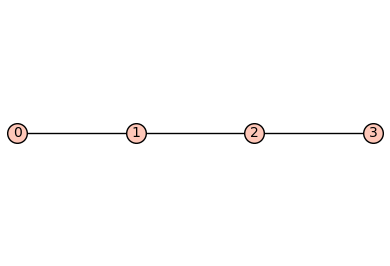

vozlišča: [0, 1, 2, 3]
povezave: [(0, 1), (1, 2), (2, 3)]
stopnje: [1, 2, 2, 1]
  α = 0.10  →  SO_α(G) = 3.58038229952095
  α = 0.50  →  SO_α(G) = 7.30056307974577
  α = 0.90  →  SO_α(G) = 15.0114183960577


In [19]:
#testiranje na primeru
G = graphs.PathGraph(4)
G.show()

print("vozlišča:", G.vertices())
print("povezave:", G.edges(labels=False))
print("stopnje:", G.degree())

alpha_values = [0.1, 0.5, 0.9]

for alpha in alpha_values:
    val = general_sombor_index(G, alpha)
    print(f"  α = {alpha:.2f}  →  SO_α(G) = {val}")


In [20]:
# funkcija, ki išče najboljša drevesa glede na Somborjev indeks
""""
def systematic_best_trees(n, Delta, alpha, return_all_best=True):
    best_val = -infinity
    best_trees = []
    
    for T in graphs.trees(n):
        if max_degree(T) > Delta:
            continue
        
        val = general_sombor_index(T, alpha)
        if val > best_val + 1e-12:
            best_val = val
            best_trees = [T]
        elif abs(val - best_val) <= 1e-12 and return_all_best:
            best_trees.append(T)
    
    return best_val, best_trees
"""

'"\ndef systematic_best_trees(n, Delta, alpha, return_all_best=True):\n    best_val = -infinity\n    best_trees = []\n    \n    for T in graphs.trees(n):\n        if max_degree(T) > Delta:\n            continue\n        \n        val = general_sombor_index(T, alpha)\n        if val > best_val + 1e-12:\n            best_val = val\n            best_trees = [T]\n        elif abs(val - best_val) <= 1e-12 and return_all_best:\n            best_trees.append(T)\n    \n    return best_val, best_trees\n'

In [21]:
#testiranje na primeru
n = 10    
Delta = 3    
alpha = 1  

best_val, best_trees = systematic_best_trees(n, Delta, alpha)

print(f"SO_{alpha:.2f}(G) = {best_val}\n")

print("Ekstremi: \n")
for i, T in enumerate(best_trees, 1):
    print(f"Drevo {i}:")
    print("stopnje vozlišč:", sorted(T.degree()))
    print("max stopnja:", max_degree(T))
    print("povezave:", T.edges(labels=False))
    T.show()  


NameError: name 'systematic_best_trees' is not defined

In [ ]:
#alpha = 0.5
#P5 = graphs.PathGraph(5)
#Star = Graph()
#Star.add_vertices(range(5))
#Star.add_edges([(0,1), (0,2), (0,3), (0,4)])
#print("Degrees P5:   ", P5.degree())
#print("Degrees Star: ", Star.degree())
#print("\nGeneral Sombor index values (alpha = 0.5):")
#print("  SO_0.5(P5)   =", general_sombor_index(P5, alpha))
#print("  SO_0.5(Star) =", general_sombor_index(Star, alpha))
#P5.show()
#Star.show()


In [ ]:
# Random tree with bounded maximum degree Δ
# funkcija, ki vrne drevo n vozlišč in največjo stopnjo manjše ali enako delta

def random_bounded_degree_tree(n, Delta):
    """
    Generate a random n-vertex tree with maximum degree <= Delta.
    Simple incremental construction: start with one vertex and
    keep attaching new vertices to random existing vertices whose
    degree is still < Delta.
    
    Assumes Delta >= 2 and n >= 1.
    """
    #if n == 1:
    #    G = Graph()
    #    G.add_vertex(0)
    #   return G
    
    G = Graph()
    G.add_vertex(0)
    
    for v in range(1, n):
        # vertices with degree < Delta
        kandidati = [u for u in G.vertices() if G.degree(u) < Delta]
        #if not kandidati:
            # This should not happen for Delta >= 2, but we guard anyway:
            #raise ValueError("No available vertex to attach new node; try larger Delta.")
        
        parent = random.choice(kandidati)
        G.add_vertex(v)
        G.add_edge(v, parent)
    
    # Sanity check:
    #if max_degree(G) > Delta:
    #    raise RuntimeError("Generated tree violates degree constraint.")
    
    return G


In [ ]:
# funkcija ki vrne drevo n vozlišč in največjo stopnjo delta

def random_tree_with_exact_max_degree(n, Delta):
    """
    Generate a random tree on n vertices whose maximum degree is EXACTLY Delta.
    SageMath version (Graph()).

    Requires n >= Delta + 1 and Delta >= 2.
    """

    if Delta < 2:
        raise ValueError("Delta must be at least 2.")
    if n < Delta + 1:
        raise ValueError("To achieve max degree = Delta, n must be >= Delta + 1.")

    G = Graph()
    G.add_vertices(range(n))

    deg = {v: 0 for v in range(n)}

    # 1) Create a star to guarantee max degree = Delta
    center = 0
    for leaf in range(1, Delta + 1):
        G.add_edge(center, leaf)
        deg[center] += 1
        deg[leaf] += 1

    next_vertex = Delta + 1

    # 2) Add remaining vertices
    while next_vertex < n:
        # Candidates are only already-created vertices
        candidatos = [u for u in range(next_vertex) if deg[u] < Delta]

        if not candidatos:
            raise RuntimeError("No valid parent available (should not happen).")

        parent = random.choice(candidatos)
        child = next_vertex

        G.add_edge(parent, child)
        deg[parent] += 1
        deg[child] += 1

        next_vertex += 1

    # Check
    if max(deg.values()) != Delta:
        raise RuntimeError("Tree does not have max degree = Delta (BUG).")

    return G

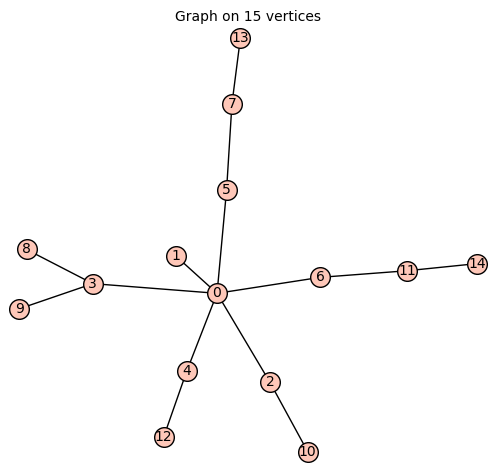

In [ ]:
random_tree_with_exact_max_degree(15, 6)

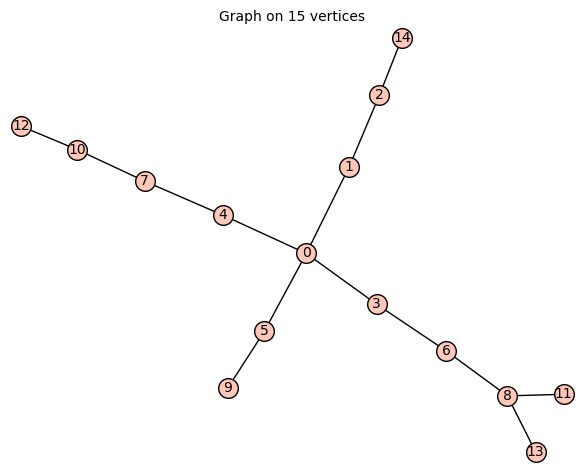

In [ ]:
random_bounded_degree_tree(15, 6)

In [ ]:
#Local move on trees (for stochastic search)
# local move by relocating a leaf


def random_tree_move(G, Delta, max_attempts=50):
    """
    Simpler local move:
      - pick a random leaf ℓ with neighbor p,
      - detach ℓ from p,
      - attach ℓ to a different vertex q with degree < Delta.
    This keeps the graph a tree and respects the max degree constraint.
    """
    H = G.copy()
    
    for _ in range(max_attempts):
        # find all leaves (degree 1 vertices)
        leaves = [v for v in H.vertices() if H.degree(v) == 1]
        if not leaves:
            return G  # shouldn't happen in a tree, but safe fallback
        
        leaf = random.choice(leaves)
        neighbor = H.neighbors(leaf)[0]  # the unique neighbor of a leaf
        
        # candidates to be the new parent of the leaf
        candidates = [
            v for v in H.vertices()
            if v != leaf and v != neighbor and H.degree(v) < Delta
        ]
        
        if not candidates:
            # no valid place to move this leaf, try another leaf/attempt
            continue
        
        new_parent = random.choice(candidates)
        
        # perform the move: detach from old parent, attach to new parent
        H.delete_edge(leaf, neighbor)
        H.add_edge(leaf, new_parent)
        
        # sanity check (should always be true, but we guard anyway)
        if H.is_tree() and max_degree(H) <= Delta:
           return H
    
    # if all attempts fail, just return the original graph
    return G



In [ ]:
#Stochastic hill-climbing search (for larger n)

def stochastic_best_tree(n, Delta, alpha, n_starts=20, n_steps=2000):
    """
    Stochastic search for trees maximizing the general Sombor index
    among n-vertex trees with maximum degree <= Delta.
    
    Uses multiple random restarts + simple hill-climbing (accepting moves
    that do not decrease SO_alpha).
    
    Parameters
    ----------
    n : int
    Delta : int
    alpha : float
    n_starts : int
        Number of random initial trees (multi-start).
    n_steps : int
        Number of local moves per start.
    verbose : bool
        If True, prints progress information.
        
    Returns
    -------
    (best_val, best_tree)
        best_val : RR
        best_tree : Graph
    """
    best_val = -infinity
    best_tree = None
    
    for s in range(n_starts):
        G = random_bounded_degree_tree(n, Delta)
        val = general_sombor_index(G, alpha)
        local_best_val = val
        local_best_tree = G
        
        #if verbose:
        #    print(f"[start {s+1}/{n_starts}] initial value = {val}")
        
        for step in range(n_steps):
            H = random_tree_move(G, Delta)
            if H is G:
                # No valid move found this attempt
                continue
            
            new_val = general_sombor_index(H, alpha)
            
            # Hill-climbing: accept if it does not decrease the value
            if new_val >= val - 1e-12:
                G, val = H, new_val
                if val > local_best_val + 1e-12:
                    local_best_val = val
                    local_best_tree = G
            
        #if verbose:
        #    print(f"  -> local best value = {local_best_val}")
        
        if local_best_val > best_val + 1e-12:
            best_val = local_best_val
            best_tree = local_best_tree
    
    return best_val, best_tree


In [ ]:
# testiranje na primeru

n = 12
Delta = 4
alpha = 0.5

#Exact (exhaustive) search
exact_val, exact_trees = systematic_best_trees(n, Delta, alpha)
exact_degrees = sorted(exact_trees[0].degree())
print("EXACT search:")
print("  best value    =", exact_val)
print("  degree seq    =", exact_degrees)

# Stochastic search
stoch_val, stoch_tree = stochastic_best_tree(
    n=n,
    Delta=Delta,
    alpha=alpha,
    n_starts=10,
    n_steps=2000
)
stoch_degrees = sorted(stoch_tree.degree())
#print("\nSTOCHASTIC search:")
print("vrednost =", stoch_val)
print("stopnje vozlišč =", stoch_degrees)



EXACT search:
  best value    = 47.5859711644328
  degree seq    = [1, 1, 1, 1, 1, 1, 1, 1, 2, 4, 4, 4]
vrednost = 47.5859711644328
stopnje vozlišč = [1, 1, 1, 1, 1, 1, 1, 1, 2, 4, 4, 4]


In [ ]:
res = classify_trees_by_max_degree_sage(8)

for delta, treelist in sorted(res.items()):
    print(f"Δ = {delta}")
    for G in treelist:
        print("  edges:", G.edges(labels=False))



Δ = 2
  edges: [(0, 1), (0, 5), (1, 2), (2, 3), (3, 4), (5, 6), (6, 7)]
Δ = 3
  edges: [(0, 1), (0, 5), (1, 2), (2, 3), (2, 4), (5, 6), (6, 7)]
  edges: [(0, 1), (0, 5), (1, 2), (2, 3), (2, 4), (5, 6), (5, 7)]
  edges: [(0, 1), (0, 5), (1, 2), (1, 4), (2, 3), (5, 6), (6, 7)]
  edges: [(0, 1), (0, 5), (1, 2), (1, 4), (2, 3), (5, 6), (5, 7)]
  edges: [(0, 1), (0, 5), (0, 7), (1, 2), (1, 4), (2, 3), (5, 6)]
  edges: [(0, 1), (0, 4), (0, 7), (1, 2), (2, 3), (4, 5), (5, 6)]
  edges: [(0, 1), (0, 4), (0, 7), (1, 2), (2, 3), (4, 5), (4, 6)]
  edges: [(0, 1), (0, 4), (0, 6), (1, 2), (2, 3), (4, 5), (6, 7)]
  edges: [(0, 1), (0, 4), (0, 7), (1, 2), (1, 3), (4, 5), (4, 6)]
  edges: [(0, 1), (0, 4), (0, 6), (1, 2), (1, 3), (4, 5), (6, 7)]
Δ = 4
  edges: [(0, 1), (0, 4), (1, 2), (2, 3), (4, 5), (4, 6), (4, 7)]
  edges: [(0, 1), (0, 4), (0, 6), (0, 7), (1, 2), (2, 3), (4, 5)]
  edges: [(0, 1), (0, 5), (1, 2), (1, 3), (1, 4), (5, 6), (5, 7)]
  edges: [(0, 1), (0, 5), (0, 7), (1, 2), (1, 3), (1, 4), 

In [ ]:
systematic_best_trees_all(4, alpha=0.2)

(4.75467957738334, [([(0, 1), (0, 2), (0, 3)], 3)])

In [ ]:
best_val, best_list = systematic_best_trees_all(10, alpha=0.2)

print("Največji Sombor indeks =", best_val)
for edges, delta in best_list:
    print("edges:", edges)
    print("delta =", delta)

Največji Sombor indeks = 21.7272759354336
edges: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9)]
delta = 9


In [ ]:
res = best_sombor_by_delta(8, alpha=1)

for delta in sorted(res.keys()):
    print(f"Δ = {delta}")
    print("  največji Sombor indeks =", res[delta]["best_val"])
    for edges, d in res[delta]["best_trees"]:
        print("  edges:", edges)
    print()

Δ = 2
  najboljši Sombor indeks = 50.0000000000000
  edges: [(0, 1), (0, 5), (1, 2), (2, 3), (3, 4), (5, 6), (6, 7)]

Δ = 3
  najboljši Sombor indeks = 86.0000000000000
  edges: [(0, 1), (0, 4), (0, 7), (1, 2), (1, 3), (4, 5), (4, 6)]

Δ = 4
  najboljši Sombor indeks = 134.000000000000
  edges: [(0, 1), (0, 5), (0, 6), (0, 7), (1, 2), (1, 3), (1, 4)]

Δ = 5
  najboljši Sombor indeks = 158.000000000000
  edges: [(0, 1), (0, 4), (0, 5), (0, 6), (0, 7), (1, 2), (1, 3)]

Δ = 6
  najboljši Sombor indeks = 230.000000000000
  edges: [(0, 1), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (1, 2)]

Δ = 7
  najboljši Sombor indeks = 350.000000000000
  edges: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7)]

